### Import libraries:

In [4]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.layers import BatchNormalization
import keras
import os
import sys
import numpy as np
import json
import argparse

rootdir_path = '/home/christosf/AttProtos/apnet'
sys.path.append(rootdir_path)
from apnet.datasets import MUSDB18Mixtures

rootdir_path = '/home/christosf/AttProtos'
sys.path.append(rootdir_path)

from attprotos.layers import PrototypeReconstruction
from attprotos.losses import prototype_loss
from attprotos.model import AttProtos
from attprotos.features import Openl3

# Features
from dcase_models.data.features import MelSpectrogram, STFT_Phase

from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.scaler import Scaler
from dcase_models.util.files import load_json, load_pickle
from dcase_models.util.files import mkdir_if_not_exists, save_pickle
from dcase_models.util.data import evaluation_setup
from dcase_models.model.container import KerasModelContainer
from dcase_models.data.feature_extractor import FeatureExtractor
from dcase_models.util.files import load_json

from keras.layers import Layer

import matplotlib.pyplot as plt

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


from keras.layers import Input, Lambda, Dense, Flatten, Multiply, Reshape, Concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import LeakyReLU, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model
from keras.regularizers import l1
import keras.backend as K

from dcase_models.model.container import KerasModelContainer
rootdir_path = '/home/christosf/AttProtos'
sys.path.append(rootdir_path)
from attprotos.losses import prototype_loss, dummy_loss
from attprotos.layers import PrototypeReconstruction

import tensorflow as tf

import librosa

from librosa.feature.inverse import mel_to_stft
from librosa.util import nnls
import librosa.display

/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/christosf/anaconda3/envs/apnet2

# MUSDB18Mixtures dataset

In [5]:
dataset = MUSDB18Mixtures('/home/christosf/AttProtos/datasets/MUSDB18Mixtures')
dataset_path = '/home/christosf/AttProtos/datasets/MUSDB18Mixtures' 

dataset.generate_file_lists()
print(dataset.label_list)
print(len(dataset.file_lists['test']))
print(len(dataset.file_lists['train']))

# Loading model and weights:

In [8]:
dataset_name = "MUSDB18Mixtures"
models_path = '/home/christosf/AttProtos/experiments'
dataset_path = './'
fold_name = "test"


model_folder = os.path.join(models_path, dataset_name, "AttProtos")
parameters_file = os.path.join(model_folder, 'config.json')

with open(parameters_file, 'r') as f:
	params = json.load(f)

params_features = params['features']["MelSpectrogram"]

params_dataset = params['datasets'][dataset_name]
params_model = params['models']["AttProtos"]

# Get and init feature class
features = MelSpectrogram(**params_features)


print('Features shape: ', features.get_shape(10.0))

Features shape:  (8, 128, 256)


/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/features.py:285: FutureWarning: Pass sr=44100, n_fft=4096, n_mels=256 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  sr, n_fft, mel_bands, **kwargs)
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/feature_extractor.py:358: FutureWarning: Pass size=462848 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  axis=0, mode=self.pad_mode
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/features.py:322: FutureWarning: Pass size=581 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  axis=0, mode='constant')
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/feature_extractor.py:372: FutureWarning: Pass frame_length=128, hop_length=64 as keyword args. From version 0

In [9]:
scaler = Scaler(normalizer=params_model['normalizer'])
# Init data generator
data_gen_test = DataGenerator(
    dataset, features, folds=[fold_name],
    batch_size=params['train']['batch_size'],
    shuffle=False, train=False, scaler=scaler
)


metrics = ['classification']

features_shape = features.get_shape()
n_frames_cnn = features_shape[1]
n_freq_cnn = features_shape[2]
n_classes = len(dataset.label_list)

print(dataset.label_list)
print(n_classes)
print(n_freq_cnn)
print(n_frames_cnn)


model_container = AttProtos(
    model=None, model_path=None, n_classes=n_classes,
    n_frames_cnn=n_frames_cnn, n_freq_cnn=n_freq_cnn,
    metrics=metrics, training=True,
    **params_model['model_arguments']
)


exp_folder = '/home/christosf/AttProtos/experiments/MUSDB18Mixtures/AttProtos/test'


scaler_file = os.path.join(exp_folder, 'scaler.pickle')
scaler = load_pickle(scaler_file)

data_gen_test = DataGenerator(
    dataset, features, folds=[fold_name],
    batch_size=params['train']['batch_size'],
    shuffle=False, train=False, scaler=scaler
)

model = model_container.model

model.load_weights('/home/christosf/AttProtos/experiments/MUSDB18Mixtures/AttProtos/test/best_weights.hdf5')

print(model.outputs)
X, Y = data_gen_test.get_data()

['vocals', 'no_vocals']
2
256
128
Instructions for updating:
Colocations handled automatically by placer.


### OVERLAPADD FOR SPECTROGRAMS

In [16]:
def overlapadddata(speech, time_context, overlap):
    sep1 = np.zeros(((len(speech)*(time_context-overlap)+time_context-34), int(speech[0].shape[-1])))
    window = np.linspace(0., 1.0, num=overlap)
    window = np.concatenate((window,window[::-1]))
    window = np.repeat(np.expand_dims(window, axis=1), int(speech[0].shape[-1]), axis=1)
    i=0
    start=0

    for sig in speech:
        #print(i)
        s1=sig
        #plt.imshow(s1)
        if start==0:
            sep1[0:time_context] = s1
        if i == len(speech)-1:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
        else:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
        i = i + 1 #index for each block
        start = start - overlap + time_context
    return sep1

In [18]:
def overlapaddspec(speech, time_context, overlap, orig):
    sep1 = np.zeros(((len(speech)*(time_context-overlap)+time_context), int(speech[0].shape[-1])))
    window = np.linspace(0., 1.0, num=overlap)
    window = np.concatenate((window,window[::-1]))
    window = np.repeat(np.expand_dims(window, axis=1), int(speech[0].shape[-1]), axis=1)
    i=0
    start=0

    for sig in speech:
        s1=sig
        #print(start)
        #plt.imshow(s1)
        if start==0:
            sep1[0:time_context] = s1
        if i == len(speech)-1:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
            sep = sep1[0:len(orig)]
        else:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
        i = i + 1 #index for each block
        start = start - overlap + time_context
    return sep

### EXPORTING ORIGINAL PHASE AND FULL SPECTROGRAM

In [20]:
FE = FeatureExtractor()

file_name = dataset.file_lists['test'][90]
y = FE.load_audio(file_name, mono=True, change_sampling_rate=False)

#ms = MelSpectrogram(**params_features, full_spectrogram=False)

msf = MelSpectrogram(**params_features, full_spectrogram=True)

#mel = ms.calculate(file_name)
melorig = msf.calculate(file_name)

features = STFT_Phase(**params_features, full_spectrogram=False)
phase = features.calculate(file_name)

/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/feature_extractor.py:358: FutureWarning: Pass size=266240 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  axis=0, mode=self.pad_mode
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/features.py:412: FutureWarning: Pass sr=44100, n_fft=4096, n_mels=256 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  sr, n_fft, mel_bands, **kwargs)
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/features.py:446: FutureWarning: Pass size=389 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  axis=0, mode='constant')


In [21]:
time_context = features.sequence_frames
overlap = int((features.sequence_frames/features.sequence_time)*2)
orig = melorig

In [22]:
data = overlapaddspec(X[220], time_context, overlap, orig)

In [23]:
melorig.shape

(261, 256)

Text(0, 0.5, 'mel filter index')

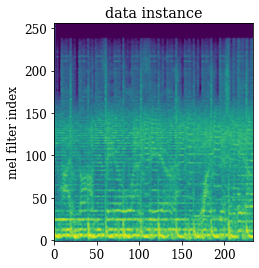

In [24]:
plt.imshow(melorig[0:234].T, origin='lower')
plt.title('data instance')
plt.ylabel('mel filter index')

### ATTENTION MAPS FOR FIRST SEGMENT OF INSTANCES

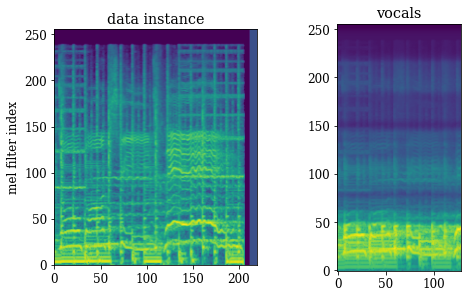

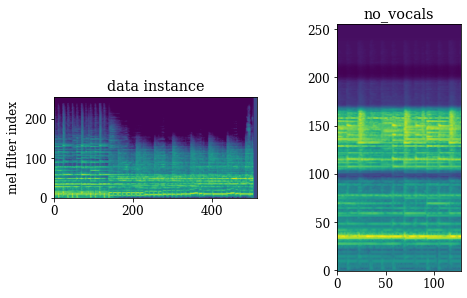

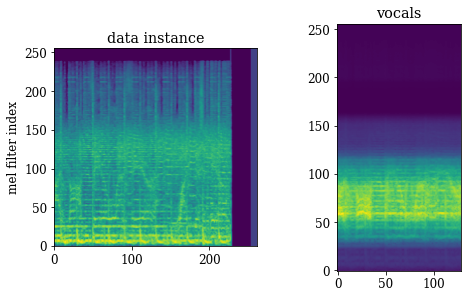

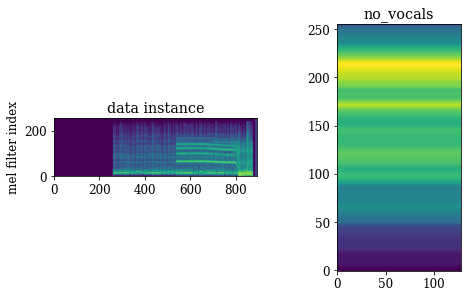

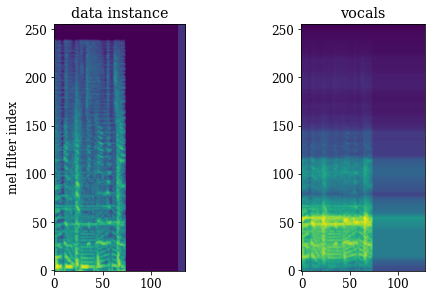

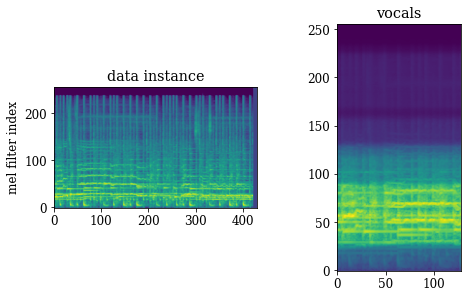

In [81]:
instances = [2, 500, 90, 800, 240, 220]
#instances = [220]
for instance in instances:
    class_ = dataset.file_to_classes[dataset.file_lists['test'][instance]]
    #print(class_)
    class_ix = [dataset.label_list.index(class_)]
    #print(class_ix)
    images = []
    #for i in range(len(X[instance])):
    pred = model_container.model.predict(X[instance])[0][0].reshape(1,-1)
    #print(pred.shape)
    alpha = model_container.model_encoder_mask.predict(X[instance])[0]
    #print(alpha.shape)

    #for class_ix in true_classes:
    logits = np.zeros_like(pred.reshape(1,-1))
    #print(logits.shape)
    #print(logits[0][class_ix])
    logits[0][class_ix] = pred[0][class_ix]
    #print(logits.shape)
    w = model_container.model.get_layer('dense').get_weights()[0]
    #print(w.T.shape)
    grad = logits.dot(w.T)
    grad = np.reshape(grad, (64, 15))
    #alpha2 = np.sum(alpha, axis=0)
    #print(alpha2.shape)
    alpha_grad = grad*alpha
    alpha_grad = alpha_grad*(alpha_grad>0)

    time_context = features.sequence_frames
    overlap = features.sequence_hop*2
    data = X[instance][0]

    saliency = np.zeros_like(data)
    energy = np.sum(alpha_grad[0]**2, axis=0) # (15,)

    profile = alpha_grad[0, :, np.argmax(energy)] # (64,)

    profile_extend = np.interp(np.arange(256), np.arange(64)*4, profile)
    profile_extend = np.convolve(profile_extend, [1/64]*64, mode='same') # (128,)
    saliency = profile_extend.copy()
    #print(saliency.shape)
    masked_data = 2*((data+1)*saliency/2) - 1 # (128x256)

    #masked_data = np.expand_dims(saliency, 0)
    #print(masked_data.shape)

    images.append(np.expand_dims(masked_data, 0))
    """data = X[instance][i]
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})    
    #plt.figure(figsize=(16,4))
    plt.figure(figsize=(8,10))
    plt.subplot(2,2,1)
    plt.imshow(data.T, origin='lower')


    plt.subplot(2,2, 2)
    plt.imshow(np.expand_dims(masked_data, 0).T, origin='lower')
    plt.title(dataset.label_list[index])
    #print(masked_data.shape)
    """
    
    #print(images[0].shape)
    #print(images[0][0].shape)
    #images = overlapaddimages(images, time_context, overlap) # 1x128x256, but 1 is the number of true classes
    images = np.concatenate(images, axis=1) 
    origdata = overlapadddata(X[instance], time_context, overlap)
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})    
    #plt.figure(figsize=(16,4))
    plt.figure(figsize=(8,10))
    plt.subplot(2,2,1)
    plt.imshow(origdata.T, origin='lower')
    plt.title('data instance')
    plt.ylabel('mel filter index')
    #plt.xlabel('hop time')
    
    #for true_class in true_classes:
        #print(true_class)
    index = dataset.label_list.index(class_)
    plt.subplot(2,2, 2)
    plt.imshow(images.T, origin='lower')
    plt.title(dataset.label_list[index])
        

# RECONSTRUCTION WITH ACC_MASK = 1-VOC_MASK

In [28]:
import scipy

In [148]:
def overlapaddspec(speech, time_context, overlap, orig):
    sep1 = np.zeros(((len(speech)*(time_context-overlap)+time_context), int(speech[0].shape[-1])))
    window = np.linspace(0., 1.0, num=overlap)
    window = np.concatenate((window,window[::-1]))
    window = np.repeat(np.expand_dims(window, axis=1), int(speech[0].shape[-1]), axis=1)
    i=0
    start=0

    for sig in speech:
        s1=sig
        #print(start)
        #plt.imshow(s1)
        if start==0:
            sep1[0:time_context] = s1
        if i == len(speech)-1:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
            sep = sep1[0:len(orig)]
        else:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
        i = i + 1 #index for each block
        start = start - overlap + time_context
    return sep

/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/features.py:446: FutureWarning: Pass size=562 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  axis=0, mode='constant')


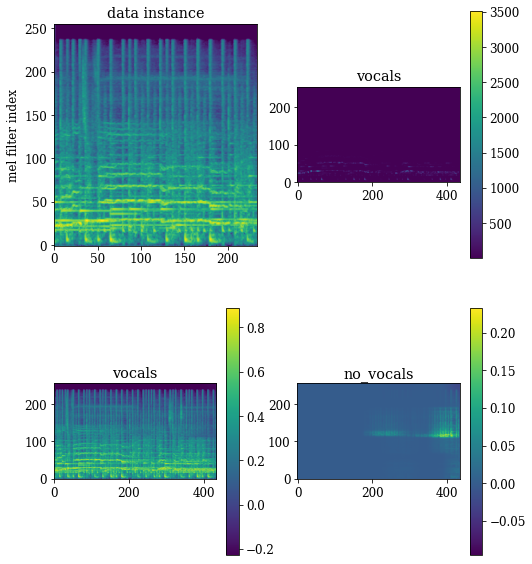

In [28]:
#instances = [2, 90, 300, 500, 220, 240]
instances = [220]
for instance in instances:
    FE = FeatureExtractor()
    file_name = dataset.file_lists['test'][instance]
    y = FE.load_audio(file_name, mono=True, change_sampling_rate=False)
    msf = MelSpectrogram(**params_features, full_spectrogram=True)
    melorig = msf.calculate(file_name)
    features = STFT_Phase(**params_features, full_spectrogram=False)
    phase = features.calculate(file_name)
    time_context = features.sequence_frames
    overlap = int((features.sequence_frames/features.sequence_time)*2)
    orig = melorig
    #images = []
    spec_v = []
    spec_a = []
    spec_o = []
    speech= []
    accomp = []
    for i in range(len(X[instance])):
        class_ix = 0
        pred = model_container.model.predict(X[instance])[0][i].reshape(1,-1)
        
        logits_voc = np.zeros_like(pred)
        logits_voc[0][0] = pred[0][0]
        
        logits_acc = np.zeros_like(pred)
        logits_acc[0][1] = pred[0][1]
        
        alpha = model_container.model_encoder_mask.predict(X[instance])[i]
        #print(alpha.shape)

        w = model_container.model.get_layer('dense').get_weights()[0]
        #print(w.shape)
        grad_voc = logits_voc.dot(w.T)
        grad_voc = np.reshape(grad_voc, (1, 64, 15))
        
        grad_acc = logits_acc.dot(w.T)
        grad_acc = np.reshape(grad_acc, (1, 64, 15))
        
        alpha2 = np.sum(alpha, axis=0)
        #print(alpha2.shape)
        
        alpha_grad_voc = grad_voc*alpha2
        alpha_grad_voc = alpha_grad_voc*(alpha_grad_voc>0)
        
        alpha_grad_acc = grad_acc*alpha2
        alpha_grad_acc = alpha_grad_acc*(alpha_grad_acc>0)
        
        data = X[instance][i]
        
        scaled = X[instance][i]
        #scaled = frame
        inversed = scaler.inverse_transform(scaled.T)
        
        melspec = librosa.db_to_power(inversed)

        saliency_voc = np.zeros_like(data)
        
        saliency_acc = np.zeros_like(data)
        #mask_i = saliency[true_class] / sum(saliency)
        #melspec_i = mask_i * data

        energy_voc = np.sum(alpha_grad_voc[0]**2, axis=0) # (15,)
        energy_acc = np.sum(alpha_grad_acc[0]**2, axis=0) # (15,)
        
        profile_voc = alpha_grad_voc[0, :, np.argmax(energy_voc)] # (64,)
        profile_acc = alpha_grad_acc[0, :, np.argmax(energy_acc)] # (64,)

        profile_voc_extend = np.interp(np.arange(256), np.arange(64)*4, profile_voc)
        profile_voc_extend = np.convolve(profile_voc_extend, [1/64]*64, mode='same') # (128,)
        saliency_voc = profile_voc_extend.copy() 
        #print(saliency_voc.shape)
        
        profile_acc_extend = np.interp(np.arange(256), np.arange(64)*4, profile_acc)
        profile_acc_extend = np.convolve(profile_acc_extend, [1/64]*64, mode='same') # (128,)
        saliency_acc = profile_acc_extend.copy() 
        #print(saliency_acc.shape)
        
        #masked_voc_data = 2*((data+1)*saliency/2) - 1 # (128x256)
        #print(masked_data.shape)
        mask_0 = saliency_voc
        mask_0 = np.expand_dims(mask_0, 0)
        
        mask_1 = saliency_acc
        #mask_1 = 1 - mask_0
        mask_1 = np.expand_dims(mask_1, 0)
        
        mask_voc = mask_0/(mask_0+mask_1)
        
        #mask_acc = mask_1/(mask_0+mask_1)
        
        #mask_voc = scipy.special.expit(mask_voc)
        #mask_voc = np.log10(0.01+mask_voc)
        #mask_voc = (mask_voc - mask_voc.min()) / (mask_voc.max() - mask_voc.min())
        
        mask_acc = 1 - mask_voc 
        
        
        #mask_acc = scipy.special.expit(mask_1)
        #mask_acc = np.log10(0.01+mask_acc)
        #mask_acc = (mask_acc - mask_acc.min()) / (mask_acc.max() - mask_acc.min())
        
        masked_spec_voc = melspec*mask_voc.T
        #masked_data_voc = mask_0*data
        masked_spec_acc = melspec*mask_acc.T
        
        inverse_voc = nnls(features.mel_basis, masked_spec_voc)
        inverse_voc = np.power(inverse_voc, 1./2.0, out=inverse_voc)
        
        inverse_acc = nnls(features.mel_basis, masked_spec_acc)
        inverse_acc = np.power(inverse_acc, 1./2.0, out=inverse_acc)
        
        polar_speech = inverse_voc * np.cos(phase[i].T) + inverse_voc * np.sin(phase[i].T) * 1j
        speech_out = librosa.istft(polar_speech, hop_length=features.audio_hop, win_length=features.audio_win, n_fft=features.n_fft, window='hann', center=True)
        
        polar_acc = inverse_acc * np.cos(phase[i].T) + inverse_acc * np.sin(phase[i].T) * 1j
        acc_out = librosa.istft(polar_acc, hop_length=features.audio_hop, win_length=features.audio_win, n_fft=features.n_fft, window='hann', center=True)

        #masked_data_acc = 1-masked_data_voc
        #plt.imshow(masked_data_voc.T, origin='lower')
        #plt.colorbar()
        #images.append(np.expand_dims(masked_data, 0))
        speech.append(speech_out)
        accomp.append(acc_out)
        dat = np.ones_like(scaled)
        #spec_v.append(inversed*mask_voc)
        #spec_a.append(inversed*mask_acc)
        spec_o.append(melspec.T)
        spec_v.append(scaled*mask_voc)
        spec_a.append(scaled*mask_acc)
        
    
    #mask_i = mask_v
    #print(masks[0].shape)
    spec = overlapaddspec(spec_o, time_context, overlap, orig)
    spec1 = overlapaddspec(spec_v, time_context, overlap, orig) # 2x128x256, but 2 is the number of all classes
    spec2 = overlapaddspec(spec_a, time_context, overlap, orig) 
    data = overlapaddspec(X[instance], time_context, overlap, orig)
    
    
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})    
    #plt.figure(figsize=(16,4))
    plt.figure(figsize=(8,10))
    plt.subplot(2,2,1)
    plt.imshow(melorig[0:234].T, origin='lower')
    plt.title('data instance')
    plt.ylabel('mel filter index')
    
    true_class = dataset.file_to_classes[dataset.file_lists['test'][instance]]
    class_ix = dataset.label_list.index(true_class)
    
    #print(true_class)
    #mask_i = images[class_ix] / sum(images)
    #melspec_i = mask_i * data
    
    plt.subplot(2,2,2)
    plt.imshow(spec.T, origin='lower')
    plt.colorbar()
    plt.title(true_class)
    
    plt.subplot(2,2,3)
    plt.imshow(spec1.T, origin='lower')
    plt.colorbar()
    plt.title('vocals')
    
    plt.subplot(2,2,4)
    plt.imshow(spec2.T, origin='lower')
    plt.colorbar()
    plt.title('no_vocals')

Text(0, 0.5, 'mel filter index')

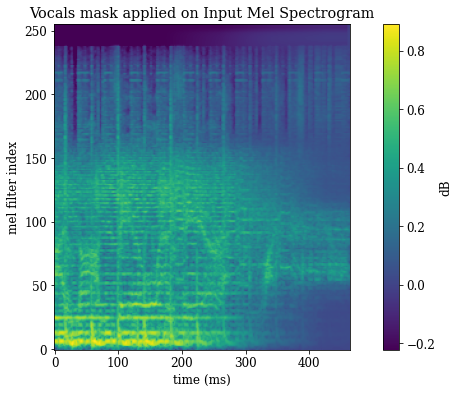

In [140]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(spec1[0:232].T, origin='lower')

#plt.title('Mel Spectrogram of Input Mixture')
plt.title('Vocals mask applied on Input Mel Spectrogram')
cbar = plt.colorbar()
cbar.set_label('dB')
#fig.colorbar(cax).set_label('Intensity [dB]')
#plt.gca().invert_yaxis()
t = plt.xticks()
ticks = t[0][1:len(t[0])-1]
labels = [int(i*2) for i in ticks]
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('time (ms)')
plt.ylabel('mel filter index')

RECONSTRUCTION

In [63]:
import math
import sys
import time
import numpy as np
import wave
import scipy
import scipy.signal
from pylab import *
import array
import os
from os.path import expanduser
import scipy.io.wavfile
import librosa
import numpy as np
from IPython.display import Audio, display
import soundfile as sf
from librosa.feature.inverse import mel_to_stft
from librosa.util import nnls
from dcase_models.data.feature_extractor import FeatureExtractor
import librosa.display
import essentia
import essentia.standard
from essentia.standard import *
from essentia.standard import OverlapAdd

In [64]:
def save_audio_to_file(x, sample_rate, outfile='out.wav'):
    """Save a mono signal to a file.
    Args:
        x (1-dim Numpy array): The audio signal to save. The signal values should be in the range [-1.0, 1.0].
        sample_rate (int): The sample rate of the signal, in Hz.
        outfile: Name of the file to save.
    """
    x_max = np.max(abs(x))
    #assert x_max <= 1.0, 'Input audio value is out of range. Should be in the range [-1.0, 1.0].'
    x = x*32767.0
    data = array.array('h')
    for i in range(len(x)):
        cur_samp = int(round(x[i]))
        data.append(cur_samp)
    f = wave.open(outfile, 'w')
    f.setparams((1, 2, sample_rate, 0, "NONE", "Uncompressed"))
    f.writeframes(data.tostring())
    f.close()

In [65]:
# play audio file. If list, play all audio files
def play_audio(path_of_wav):
    if isinstance(path_of_wav, list):
        for item in path_of_wav:
            display(Audio(item))
    else:
        display(Audio(path_of_wav))

In [139]:
def overlapadd(speech, time_context, overlap):
    len(y)
    sep1 = np.zeros((((len(speech)*(time_context-overlap)+time_context), )))
    window = np.linspace(0., 1.0, num=overlap)
    window = np.concatenate((window,window[::-1]))
    #window = np.expand_dims(window, axis=1)
    i=0
    start=0

    for sig in speech:
        s1=sig
        if start==0:
            sep1[0:time_context] = s1
            sep1[0:overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
        if i == len(speech)-1:
            #print(start)
            #diff = len(s1[overlap:time_context])-len(sep1[start+overlap:start+time_context])
            #print(diff)
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
            sep=sep1[0:len(y)]
        else:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
        i = i + 1 #index for each block
        start = start - overlap + time_context
    return sep

In [151]:
time_context = len(speech[0])
overlap = int(time_context/2) - int(features.audio_hop/2)

In [152]:
signal = overlapadd(speech, time_context, overlap)

In [153]:
accompaniment = overlapadd(accomp, time_context, overlap)

In [154]:
sf.write('voc.wav', signal, 44100)
play_audio('voc.wav')

In [144]:
sf.write('acc.wav', accompaniment, 44100)
play_audio('acc.wav')